In [4]:
# %run ./model_end_events_for_outages_METHODS.ipynb

In [26]:
from importlib import reload
#---------------------------------------------------------------------
import sys, os
import re
from pathlib import Path
import json
import pickle
import joblib

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
from sklearn.metrics import precision_recall_curve

import copy
import itertools
import adjustText

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
from OutagePredictor import OutagePredictor
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, CombinedSQLWhereElements, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer
#---------------------------------------------------------------------

In [8]:
def plot_pred_probs_for_trsf_i(
    fig_num            , 
    trsf_pole_nb_i     , 
    y_prob1_by_date_df , 
    dovs_df            , 
    trsf_pole_nb_col   = 'trsf_pole_nb', 
    outg_rec_nb_col    = 'OUTG_REC_NB', 
    dt_off_ts_full_col = 'DT_OFF_TS_FULL', 
    plot_maxima        = False, 
    maxima_colors      = ['green', 'lawngreen']
):
    r"""
    dovs_df:
        Must be merged with MeterPremise so that it contains trsf_pole_nb_col
    """
    #-------------------------
    fig,ax = Plot_General.default_subplots(fig_num=fig_num)
    #-------------------------
    y_prob1_by_date_df.loc[trsf_pole_nb_i].T.plot.line(ax=ax)
    ax.axhline(0.5, color='cyan')
    #-------------------------
    dovs_df_i = dovs_df[dovs_df[trsf_pole_nb_col]==trsf_pole_nb_i][[outg_rec_nb_col, dt_off_ts_full_col]].drop_duplicates()
    if dovs_df_i.shape[0]>0:
        for idx_ij in range(dovs_df_i.shape[0]):
            dt_off_ts_full_ij = dovs_df_i.iloc[idx_ij][dt_off_ts_full_col]
            ax.axvline(dt_off_ts_full_ij, color='red', lw=5, alpha=0.5)
    ax.set_title(f'trsf_pole_nb = {trsf_pole_nb_i}')
    #-------------------------
    ax.set_ylim(0,1);
    #-------------------------
    if plot_maxima:
        idx_max_i = y_prob1_by_date_df.loc[trsf_pole_nb_i].idxmax()
        ax.axvline(idx_max_i, color=maxima_colors[0])
        if(
            idx_max_i > dovs_df_i[dt_off_ts_full_col].max() and
            y_prob1_by_date_df.loc[trsf_pole_nb_i].index[0] < dovs_df_i[dt_off_ts_full_col].max() #Make sure there are actually data to grab
        ):
            idx_max_i = y_prob1_by_date_df.loc[trsf_pole_nb_i][:dovs_df_i[dt_off_ts_full_col].max()].idxmax()
            ax.axvline(idx_max_i, color=maxima_colors[1])
    #-------------------------
    if dovs_df_i[dt_off_ts_full_col].min() < y_prob1_by_date_df.loc[trsf_pole_nb_i].index[0]:
        ax.set_xlim(left=dovs_df_i[dt_off_ts_full_col].min()-pd.Timedelta('1D'))    
    #-------------------------
    return fig,ax

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_min=None, x_max=None):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlim(x_min,x_max)
    plt.legend()
    
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal

In [10]:
#----------------------------------------------------------------------------------------------------
def find_longest_consec_len_in_bool_srs(
    bool_srs
):
    r"""
    Given a pd.Series, srs, comprised of boolean values, determine the longest streak of consecutive True values.
    Assumption is that bool_srs has been sorted to fit needs before being fit into this function.
    """
    #-------------------------
    assert(bool_srs.dtype==bool)
    #-------------------------
    longest = 0
    streak = 0
    for idx_i, bool_i in bool_srs.items():
        if bool_i==True:
            streak += 1
        else:
            longest = max(longest, streak)
            streak = 0
    # Make sure the last streak isn't ignored if series ends with True
    longest = max(longest, streak)
    #-------------------------
    return longest

def find_longest_consec_idxs_in_bool_srs(
    bool_srs, 
    return_ilocs=False, 
    return_len=False
):
    r"""
    Given a pd.Series, srs, comprised of boolean values, determine the longest streak of consecutive True values and return the indices.
    Returns:
        A pair of indices representing the beginning and ending of the True block
        The returned indices are INCLUSIVE, meaning bool_srs.loc[return_idxs[0]]==True and bool_srs.loc[return_idxs[1]]==True
        
    return_ilocs:
        If True, instead of returning the values in bool_srs.index, return integers between 0 and bool_srs.shape[0]-1
        
    return_len:
        If True, also return the length of the block, in integer form
    
    Assumption is that bool_srs has been sorted to fit needs before being fit into this function.
    """
    #-------------------------
    assert(bool_srs.dtype==bool)
    #-------------------------
    longest = 0
    streak = 0
    #-----
    locs = [np.nan, np.nan]
    curr_beg_loc = bool_srs.index[0]
    #-----
    ilocs = [np.nan, np.nan]
    curr_beg_iloc = 0
    #-------------------------
    for i in range(bool_srs.shape[0]):
        idx_i  = bool_srs.index[i]
        bool_i = bool_srs.iloc[i]
        #-----
        if bool_i==True:
            streak += 1
        else:
            if streak >= longest:
                longest = streak
                locs  = [curr_beg_loc,  idx_i]
                ilocs = [curr_beg_iloc, i]
            #-----
            streak = 0
            if i < bool_srs.shape[0]-1:
                curr_beg_loc  = bool_srs.index[i+1]
                curr_beg_iloc = i+1
    # Make sure the last streak isn't ignored if series ends with True
    if streak >= longest:
        longest = streak
        locs  = [curr_beg_loc, idx_i]
        ilocs = [curr_beg_iloc, bool_srs.shape[0]-1] 
    #-------------------------
    return_idxs = locs
    if return_ilocs:
        return_idxs = ilocs
    #-------------------------
    if return_len:
        return return_idxs, longest
    else:
        return return_idxs


#----------------------------------------------------------------------------------------------------
def get_prob1_i_stats_preceding_date(
    y_prob1_i, 
    date, 
    pd_len=pd.Timedelta('7D'),
    exclude_day_of=True, 
    threshold=0.5, 
    return_series=True, 
    cols_to_drop=None
):
    r"""
    Return information regarding the probability prediction in the period of length pd_len preceding date
    
    date:
        If not supplied, will be randomly selected from y_prob1_i.index UNLESS pd_len is also not supplied (see NEITHER date/pd_len supplied)
        
    pd_len:
        If not supplied, all available data preceding date will be used UNLESS date is also not supplied (see NEITHER date/pd_len supplied)
        
    NEITHER date/pd_len supplied:
        If neither is supplied, entire series y_prob1_i is evaluated
    """
    #--------------------------------------------------
    assert(isinstance(y_prob1_i, pd.Series))
    y_prob1_i = copy.deepcopy(y_prob1_i)
    if cols_to_drop is not None:
        y_prob1_i = y_prob1_i.drop(cols_to_drop)
    #--------------------------------------------------
    # If date is None and pd_len is None, no slicing done on y_prob1_i (i.e., y_prob1_i=y_prob1_i instead
    #   of y_prob1_i = y_prob1_i.loc[pd.Timestamp(date-pd_len) : pd.Timestamp(date)])
    # Put differently, slicing is needed if date is not None or pd_len is not None
    if(
        date   is not None or 
        pd_len is not None
    ):
        #-------------------------
        if date is None:
            date_0 = y_prob1_i.index.min()
            date_1 = y_prob1_i.index.max()
            if exclude_day_of:
                # To ensure date_0 remains within bounds of y_prob1_i
                date_0 = date_0+pd.Timedelta('1D')
            #-----
            date = Utilities_dt.get_random_date_interval_between(
                date_0       = date_0, 
                date_1       = date_1, 
                window_width = pd_len, 
                rand_seed    = None
            )
            date = date[1]
        #-------------------------
        if pd_len is None:
            pd_len = date-y_prob1_i.index.min()
            if exclude_day_of:
                pd_len = pd_len-pd.Timedelta('1D')
        #-------------------------
        # Being extra safe, don't want safe changed outside of function
        date = copy.deepcopy(date)
        #-------------------------
        # Ensure date is a date object, and not datetime
        assert(Utilities.is_object_one_of_types(date, [pd.Timestamp, datetime.date]))
        if isinstance(date, pd.Timestamp):
            date = date.date()
        assert(isinstance(date, datetime.date))
        #-------------------------
        if exclude_day_of:
            date = date-pd.Timedelta('1D')
        #-------------------------
        if(
            pd.Timestamp(date-pd_len) < y_prob1_i.index.min() or 
            pd.Timestamp(date) > y_prob1_i.index.max()
        ):
            return None
        #-------------------------
        y_prob1_i = y_prob1_i.loc[pd.Timestamp(date-pd_len) : pd.Timestamp(date)]
    #--------------------------------------------------
    n_nan                          = y_prob1_i.isna().sum()
    n_abv_thrsh                    = (y_prob1_i > threshold).sum()
    idxs, longest_streak_abv_thrsh = find_longest_consec_idxs_in_bool_srs(
        bool_srs     = y_prob1_i>threshold, 
        return_ilocs = False, 
        return_len   = True
    )
    #--------------------------------------------------
    if date is None:
        longest_streak_beg = y_prob1_i.index.max()-idxs[0]
        longest_streak_end = y_prob1_i.index.max()-idxs[1]
    else:
        longest_streak_beg = pd.Timestamp(date)-idxs[0]
        longest_streak_end = pd.Timestamp(date)-idxs[1]
    #-----
    return_dict = dict(
        n_nan                    = n_nan, 
        n_abv_thrsh              = n_abv_thrsh, 
        longest_streak_abv_thrsh = longest_streak_abv_thrsh, 
        longest_streak_beg       = longest_streak_beg, 
        longest_streak_end       = longest_streak_end
    )
    #--------------------------------------------------
    if return_series:
        return pd.Series(return_dict)
    else:
        return return_dict

In [12]:
#-------------------------
# New meter_events.events_summary_vw table became live on 2023-04-01
# Therefore, we can only really assess outages occurring on/after 2023-05-02 (due to 31-day look)

In [18]:
prediction_date   = pd.to_datetime('2023-07-27')

In [20]:
self = OutagePredictor(prediction_date=prediction_date)
#-----
self.set_model_dir(r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20231201\Models\All_EEMSP_agg_Top10_v4')
#-----
self.set_trsf_pole_nbs_from_sql(
    n_trsf_pole_nbs=1000, 
    states='OH'
)
print(f"n_trsf_pole_nbs = {len(self.trsf_pole_nbs)}")
print(f"\nSQL statement:\n{self.trsf_pole_nbs_sql}")
#-----
self.initialize_data(
    evsSum_sql_fcn=AMIEndEvents_SQL.build_sql_end_events,  
    evsSum_sql_kwargs=dict(opco='oh'), 
)

C:\Users\s346557\Documents\Analysis\MeterPremise.py:3035: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_aws)


n_trsf_pole_nbs = 1000

SQL statement:
WITH SSO AS (
	SELECT DISTINCT
		MP.trsf_pole_nb
	FROM default.meter_premise MP
	WHERE MP.state_cd = 'OH'
)
SELECT *
FROM SSO
ORDER BY RAND()
LIMIT 1000
n_coll     = 1000
batch_size = 1000
n_batches  = 1


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\OutagePredictor.py:799: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_i = pd.read_sql_query(sql_i, conn_aws)
C:\Users\s346557\Documents\Analysis\OutagePredictor.py:1401: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  self.__regex_setup_df = pd.read_sql(sql, self.conn_aws, dtype=str)


n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


In [28]:
# Make predictions
y_pred = self.model_clf.predict(self.X_test)
y_scores = self.model_clf.predict_proba(self.X_test)
precisions, recalls, thresholds = precision_recall_curve(y_pred, y_scores[:,1])

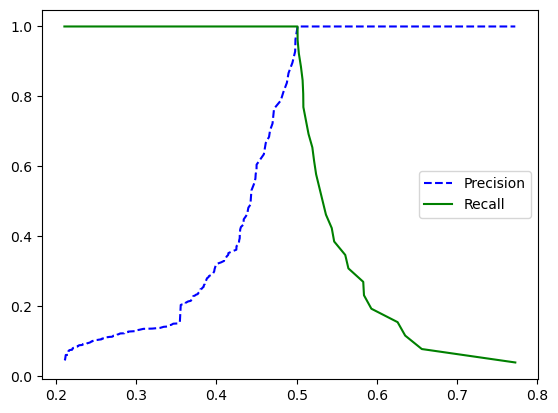

In [37]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [39]:
# Sanity check
threshold=0.5
y_pred_from_proba = [int(x>threshold) for x in y_scores[:, 1]]
assert(all(y_pred_from_proba==y_pred))

In [ ]:
assert(0)

In [43]:
# prediction_dates = pd.date_range(
#     start = pd.to_datetime('2023-05-02'), 
#     end   = pd.to_datetime('2023-09-30'), 
#     freq  = pd.Timedelta('1D')
# )

prediction_dates = pd.date_range(
    start = pd.to_datetime('2023-05-02'), 
    end   = pd.to_datetime('2023-05-12'), 
    freq  = pd.Timedelta('1D')
)
prediction_dates

DatetimeIndex(['2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
               '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09',
               '2023-05-10', '2023-05-11', '2023-05-12'],
              dtype='datetime64[ns]', freq='D')

In [50]:
outg_prdctr = OutagePredictor(prediction_date=prediction_dates[0])
#-----
outg_prdctr.set_model_dir(r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20231201\Models\All_EEMSP_agg_Top10_v4')
#-----
trsf_pole_nbs = self.trsf_pole_nbs
outg_prdctr.set_trsf_pole_nbs(trsf_pole_nbs)
print(f"n_trsf_pole_nbs = {len(outg_prdctr.trsf_pole_nbs)}")
#-----
# outg_prdctr.initialize_data(
#     evsSum_sql_fcn=AMIEndEvents_SQL.build_sql_end_events,  
#     evsSum_sql_kwargs=dict(opco='oh'), 
# )

outg_prdctr.prep_multiple_prediction_dates(
    prediction_dates  = prediction_dates, 
    predictions_range = None, 
    evsSum_sql_fcn    = AMIEndEvents_SQL.build_sql_end_events,  
    evsSum_sql_kwargs = dict(opco='oh'), 
    save_args         = False
)

n_trsf_pole_nbs = 1000
n_coll     = 1000
batch_size = 1000
n_batches  = 1


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\OutagePredictor.py:799: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_i = pd.read_sql_query(sql_i, conn_aws)
C:\Users\s346557\Documents\Analysis\OutagePredictor.py:799: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_i = pd.read_sql_query(sql_i, conn_aws)
C:\Users\s346557\Documents\Analysis\OutagePredictor.py:799: UserWarning: pandas onl

In [52]:
start = time.time()

results_dict = dict()
for prediction_date_i in prediction_dates:
    print(prediction_date_i)
    assert(prediction_date_i not in results_dict)
    outg_prdctr.change_prediction_date(prediction_date=prediction_date_i)
    y_pred_i   = outg_prdctr.model_clf.predict(outg_prdctr.X_test)
    y_scores_i = outg_prdctr.model_clf.predict_proba(outg_prdctr.X_test)
    #-----
    assert(outg_prdctr.rcpx_df.shape[0]==len(y_pred_i))
    assert(outg_prdctr.rcpx_df.shape[0]==len(y_scores_i))
    res_i = pd.DataFrame(
        index=outg_prdctr.rcpx_df.index, 
        data=dict(
            y_pred=y_pred_i, 
            y_prob_0=[x[0] for x in y_scores_i], 
            y_prob_1=[x[1] for x in y_scores_i]
        )
    )    
    #-----
    results_dict[prediction_date_i] = res_i

print(time.time()-start)

2023-05-02 00:00:00


C:\Users\s346557\Documents\Analysis\OutagePredictor.py:1401: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  self.__regex_setup_df = pd.read_sql(sql, self.conn_aws, dtype=str)


n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-03 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-04 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-05 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-06 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-07 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-08 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-09 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-10 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-11 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


2023-05-12 00:00:00
n_coll     = 1000
batch_size = 10000
n_batches  = 1
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


238.23787808418274


In [59]:
return_df = pd.DataFrame()
for i, (prediction_date_i, df_i) in enumerate(results_dict.items()):
    df_i = Utilities_df.prepend_level_to_MultiIndex(
        df=df_i, 
        level_val=prediction_date_i, 
        axis=1
    )
    if i==0:
        return_df = df_i.copy()
    else:
        return_df = pd.merge(
            return_df, 
            df_i, 
            left_index=True, 
            right_index=True, 
            how='outer'
        )

In [67]:
y_pred_by_date_df  = return_df.xs('y_pred', level=1, axis=1)
y_prob1_by_date_df = return_df.xs('y_prob_1', level=1, axis=1)

<Axes: >

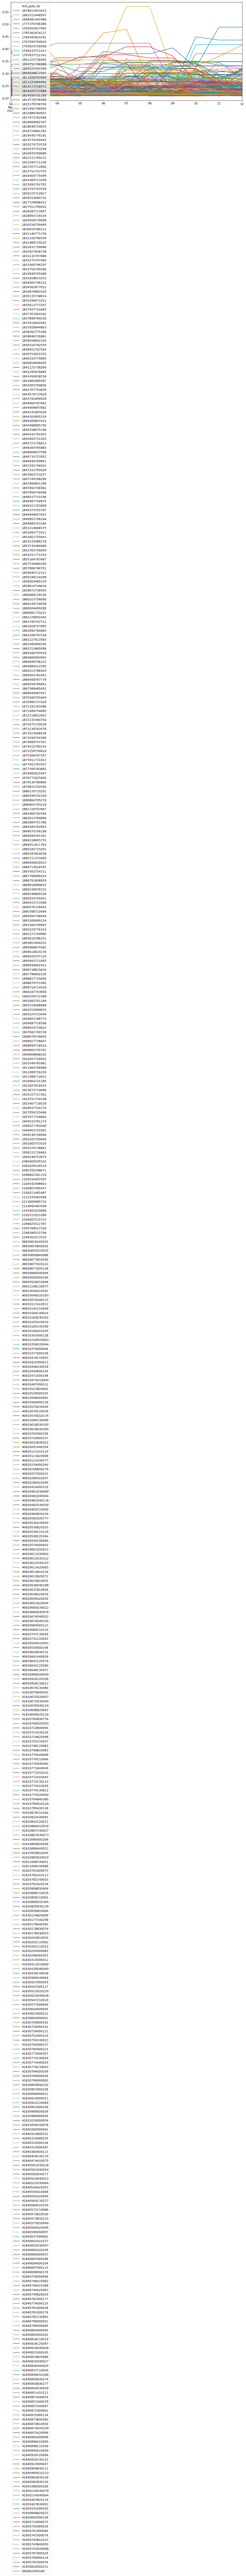

In [69]:
fig,ax = Plot_General.default_subplots()
y_prob1_by_date_df.T.plot.line(ax=ax)

<Axes: >

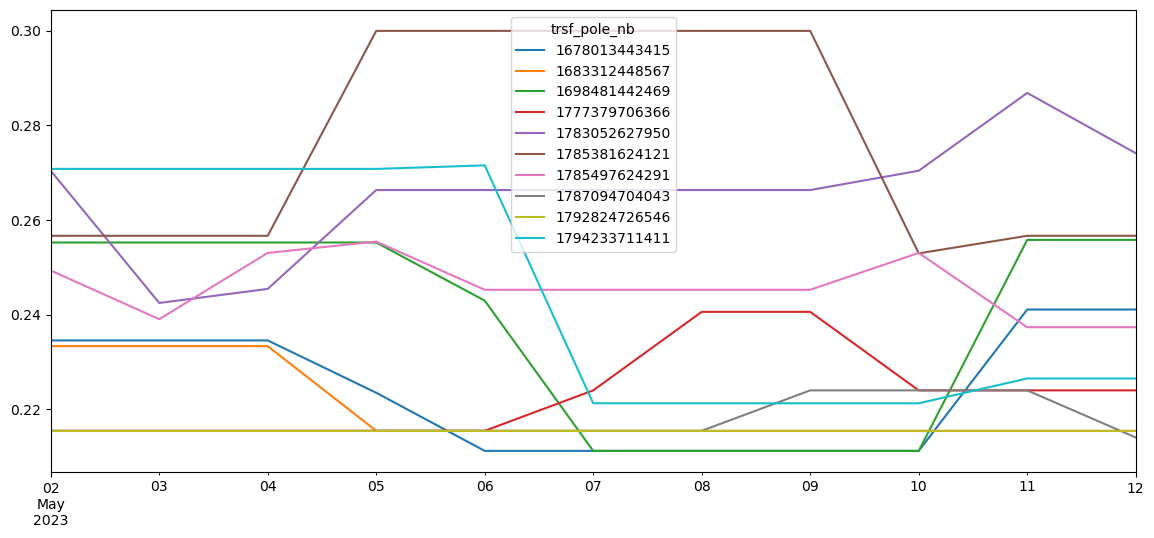

In [71]:
fig,ax = Plot_General.default_subplots()
y_prob1_by_date_df.iloc[:10].T.plot.line(ax=ax)

In [73]:
df_mp_install_time_col = 'inst_ts'
df_mp_removal_time_col = 'rmvl_ts'
dt_0 = prediction_dates[0]
dt_1 = prediction_dates[-1]

In [75]:
mp_df = MeterPremise.build_mp_df_curr_hist_for_xfmrs(
    trsf_pole_nbs               = self.rcpx_df.index.tolist(), 
    join_curr_hist              = True, 
    addtnl_mp_df_curr_cols      = None, 
    addtnl_mp_df_hist_cols      = None, 
    assume_one_xfmr_per_PN      = True, 
    drop_approx_duplicates      = True, 
    drop_approx_duplicates_args = None, 
    df_mp_serial_number_col     = 'mfr_devc_ser_nbr', 
    df_mp_prem_nb_col           = 'prem_nb', 
    df_mp_install_time_col      = 'inst_ts', 
    df_mp_removal_time_col      = 'rmvl_ts', 
    df_mp_trsf_pole_nb_col      = 'trsf_pole_nb'
)

# Only want meters active at the relevant time period
mp_df = mp_df[(mp_df[df_mp_install_time_col]<=pd.to_datetime(dt_0)) & 
              (mp_df[df_mp_removal_time_col].fillna(pd.Timestamp.max)>pd.to_datetime(dt_1))]

n_coll     = 577
batch_size = 1000
n_batches  = 1


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


n_coll     = 2730
batch_size = 1000
n_batches  = 3


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


In [77]:
# Build dovs_df
dovs = DOVSOutages(
    df_construct_type         = DFConstructType.kRunSqlQuery, 
    contstruct_df_args        = None, 
    init_df_in_constructor    = True,
    build_sql_function        = DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs = dict(
        premise_nbs     = mp_df['prem_nb'].unique().tolist(), 
        date_range      = [dt_0, dt_1], 
        field_to_split  = 'premise_nbs', 
        include_premise = True
    ), 
    build_consolidated        = False
)
dovs_df = dovs.df.copy()

n_coll     = 2708
batch_size = 1000
n_batches  = 3
!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


!!!!! WARNING !!!!! NO OPCOs SELECTED!


C:\Users\s346557\Documents\Analysis\GenAn.py:662: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


In [78]:
dovs_df = pd.merge(
    dovs_df, 
    mp_df[['prem_nb', 'trsf_pole_nb']].drop_duplicates(), 
    left_on  = 'PREMISE_NB', 
    right_on = 'prem_nb', 
    how      = 'left'
)
dovs_df

,CI_NB,CMI_NB,OUTG_REC_NB,OUTAGE_NB,DT_ON_TS,DT_OFF_TS,DT_OFF_TS_FULL,STEP_DRTN_NB,START_YEAR,OPERATING_UNIT_ID,...,SHORT_NM_CLR_DEV,EQUIP_TYP_NM,SHORT_NM_EQP_TYP,MJR_CAUSE_NM,MNR_CAUSE_NM,REST_TM,PREMISE_NB,OFF_TM,prem_nb,trsf_pole_nb
0,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,100455530,2023-05-12 23:30:00,100455530,1859614744634
1,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,103555530,2023-05-12 23:30:00,103555530,1859614744634
2,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,105827740,2023-05-12 23:30:00,105827740,1859614744634
3,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,108927740,2023-05-12 23:30:00,108927740,1859614744634
4,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,107255530,2023-05-12 23:30:00,107255530,1859614744634
5,150,27450.0,13352984,3039331,2023-05-13 02:33:00,2023-05-12,2023-05-12 23:30:00,183.0,2023,3,...,LINE FUSE,FUSE,FUSE,DISTRIBUTION LINE,EQUIPMENT FAILURE,2023-05-13 02:30:00,108845530,2023-05-12 23:30:00,108845530,1859614744634
6,582,13968.0,13343080,3020591,2023-05-08 10:59:00,2023-05-08,2023-05-08 10:35:00,24.0,2023,3,...,PRI OPEN,CROSSARM,CROSSARM,DISTRIBUTION LINE,SCHEDULED COMPANY,2023-05-08 10:59:00,100001382,2023-05-08 10:35:00,100001382,1884238805755
7,582,13968.0,13343080,3020591,2023-05-08 10:59:00,2023-05-08,2023-05-08 10:35:00,24.0,2023,3,...,PRI OPEN,CROSSARM,CROSSARM,DISTRIBUTION LINE,SCHEDULED COMPANY,2023-05-08 10:59:00,101795783,2023-05-08 10:35:00,101795783,1889246809156
8,582,13968.0,13343080,3020591,2023-05-08 10:59:00,2023-05-08,2023-05-08 10:35:00,24.0,2023,3,...,PRI OPEN,CROSSARM,CROSSARM,DISTRIBUTION LINE,SCHEDULED COMPANY,2023-05-08 10:59:00,106201382,2023-05-08 10:35:00,106201382,1884238805755
9,582,13968.0,13343080,3020591,2023-05-08 10:59:00,2023-05-08,2023-05-08 10:35:00,24.0,2023,3,...,PRI OPEN,CROSSARM,CROSSARM,DISTRIBUTION LINE,SCHEDULED COMPANY,2023-05-08 10:59:00,109301382,2023-05-08 10:35:00,109301382,1884238805755


In [79]:
# Set predictions column in self.rcpx_df
assert(self.rcpx_df.shape[0]==y_pred.shape[0])
self.rcpx_df['y_pred'] = y_pred

In [80]:
mp_df_pred1 = mp_df[mp_df['trsf_pole_nb'].isin(self.rcpx_df[self.rcpx_df['y_pred']==1].index.tolist())].copy()
dovs_df_pred1 = dovs_df[dovs_df['PREMISE_NB'].isin(mp_df_pred1['prem_nb'].unique().tolist())]
#-----
mp_df_pred0 = mp_df[mp_df['trsf_pole_nb'].isin(self.rcpx_df[self.rcpx_df['y_pred']==0].index.tolist())].copy()
dovs_df_pred0 = dovs_df[dovs_df['PREMISE_NB'].isin(mp_df_pred0['prem_nb'].unique().tolist())]

In [95]:
# fig_num = 0
# trsf_pole_nb_i = '1875796723704'

# fig,ax = plot_pred_probs_for_trsf_i(
#     fig_num            = fig_num, 
#     trsf_pole_nb_i     = trsf_pole_nb_i, 
#     y_prob1_by_date_df = y_prob1_by_date_df, 
#     dovs_df            = dovs_df, 
#     trsf_pole_nb_col   = 'trsf_pole_nb', 
#     outg_rec_nb_col    = 'OUTG_REC_NB', 
#     dt_off_ts_full_col = 'DT_OFF_TS_FULL', 
#     plot_maxima        = True
# )
# ax.set_ylim(0,1)
# fig_num+=1

In [89]:
fig_num = 0
assert(y_prob1_by_date_df.index.nunique()==y_prob1_by_date_df.shape[0])

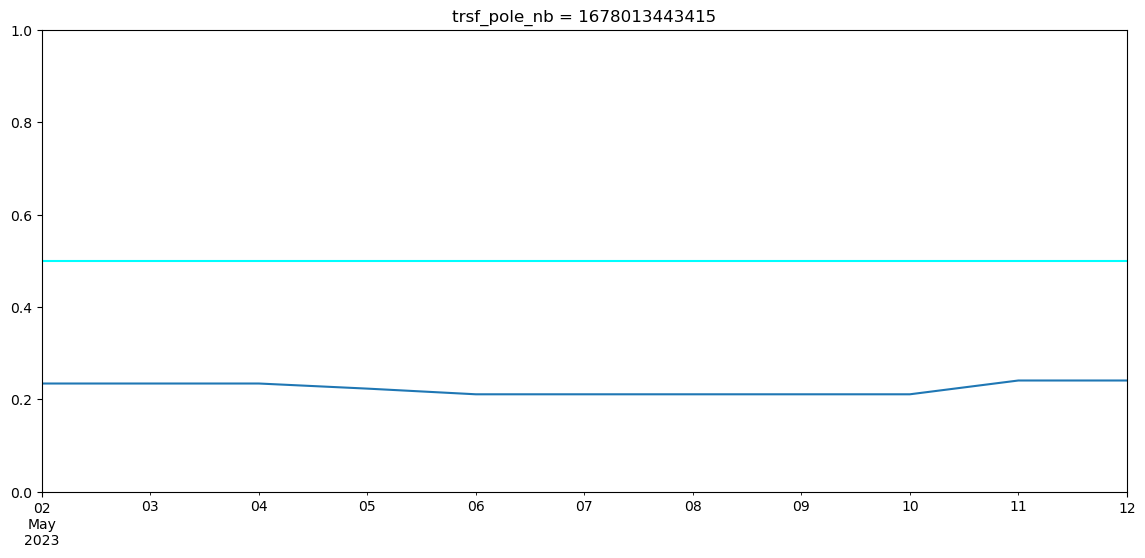

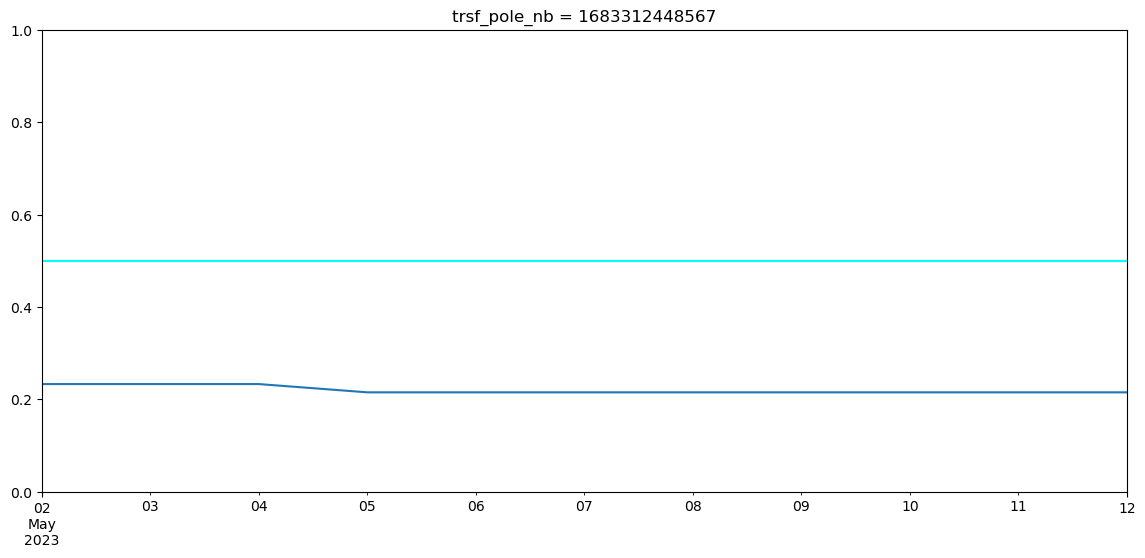

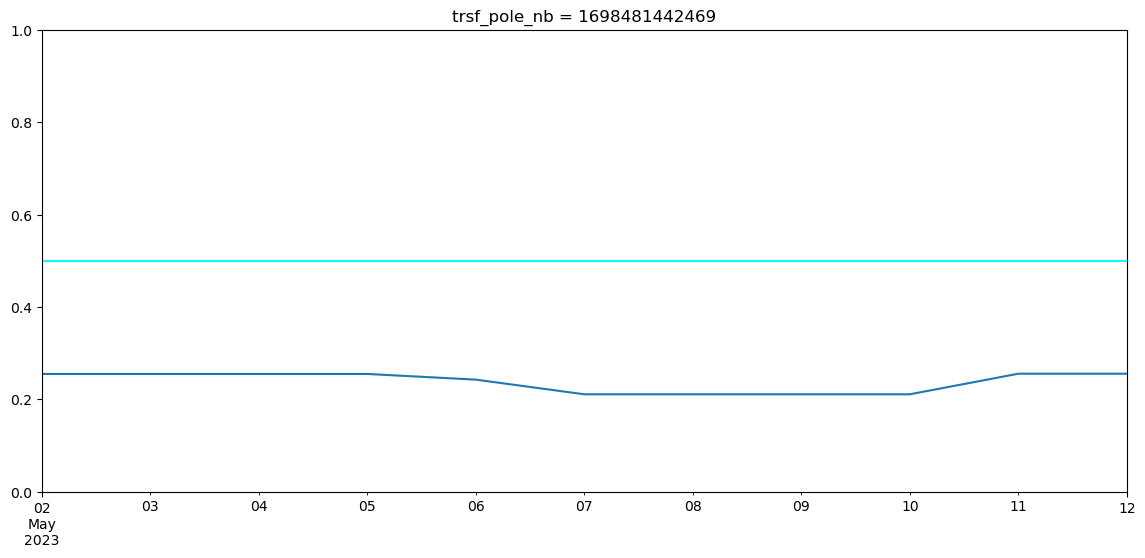

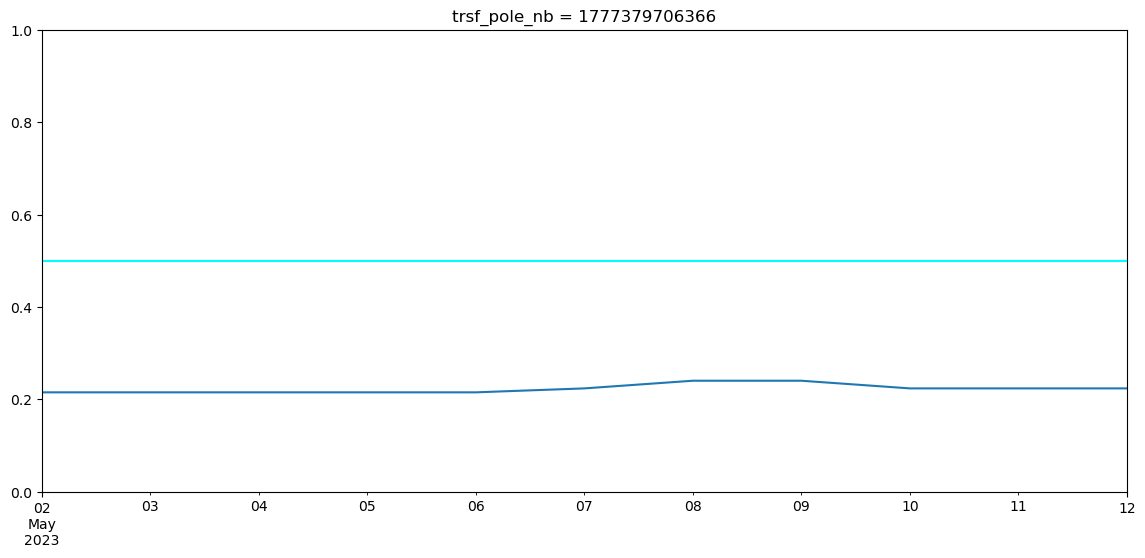

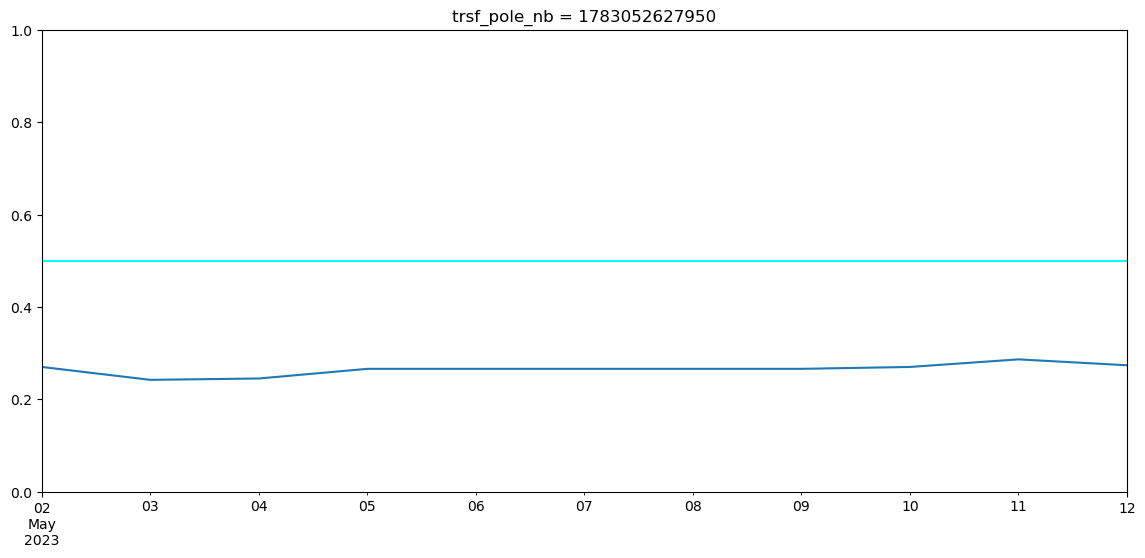

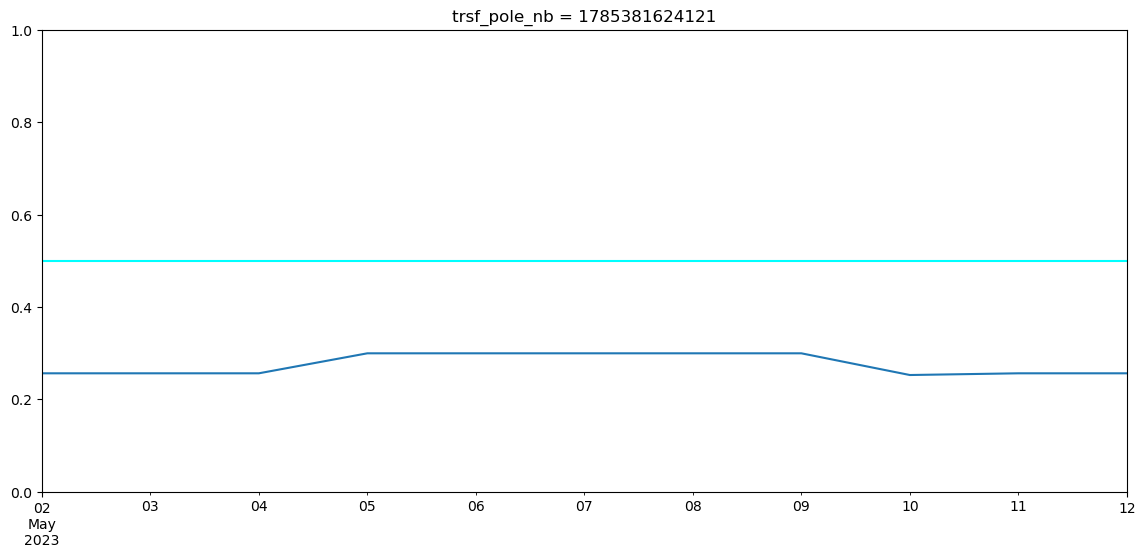

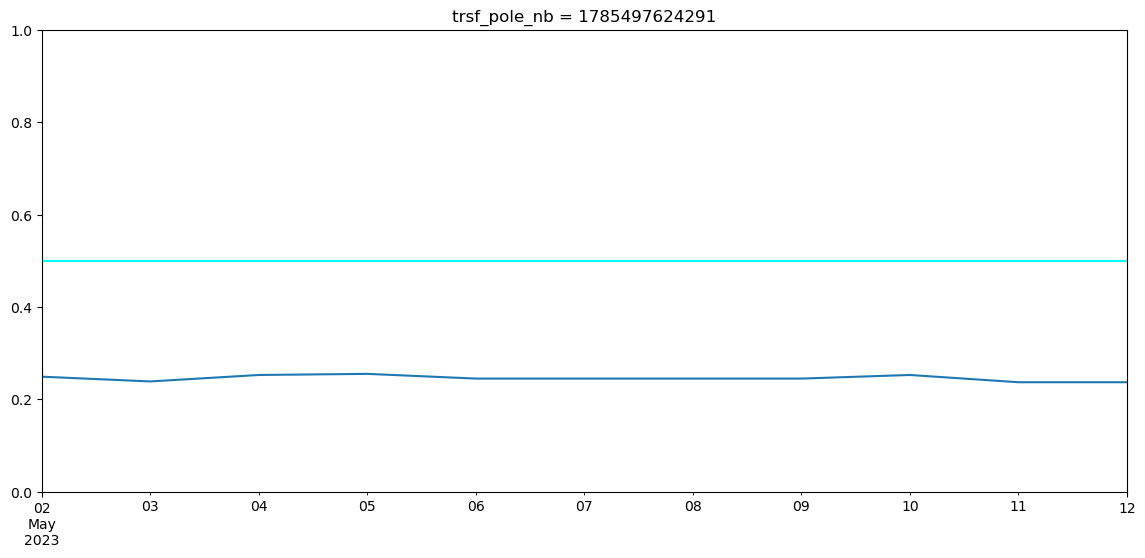

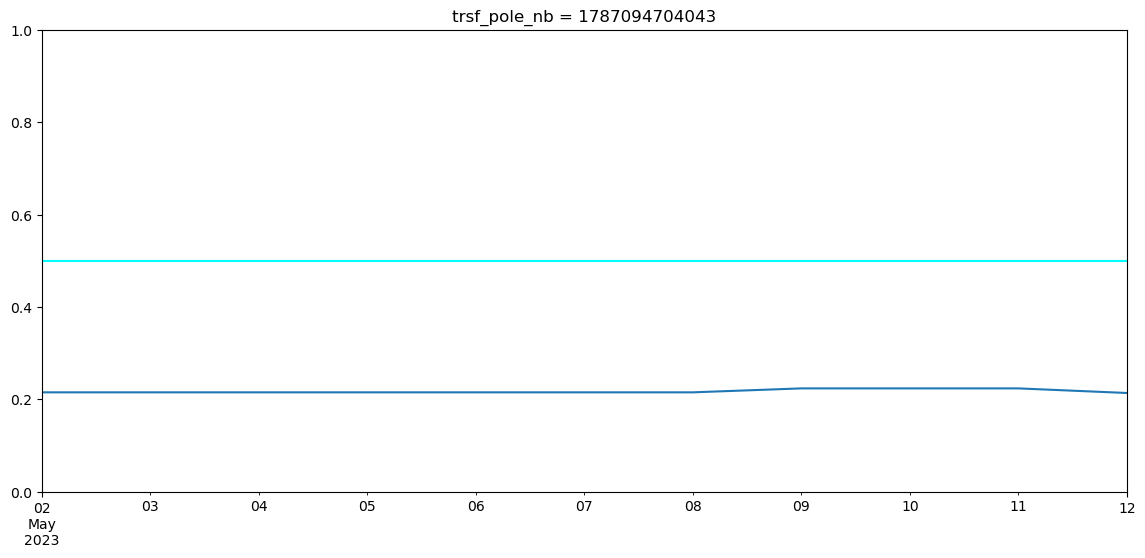

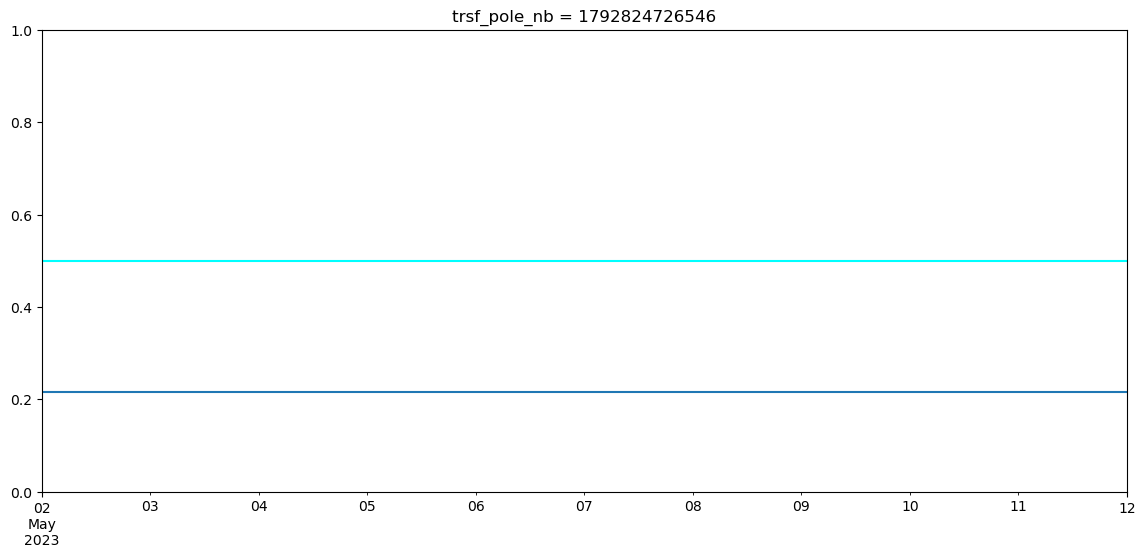

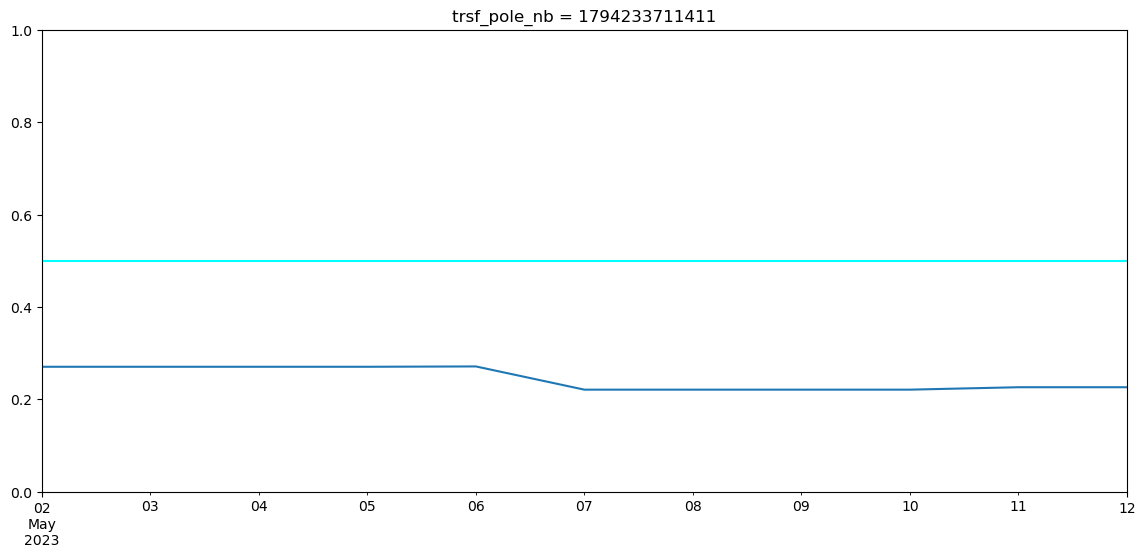

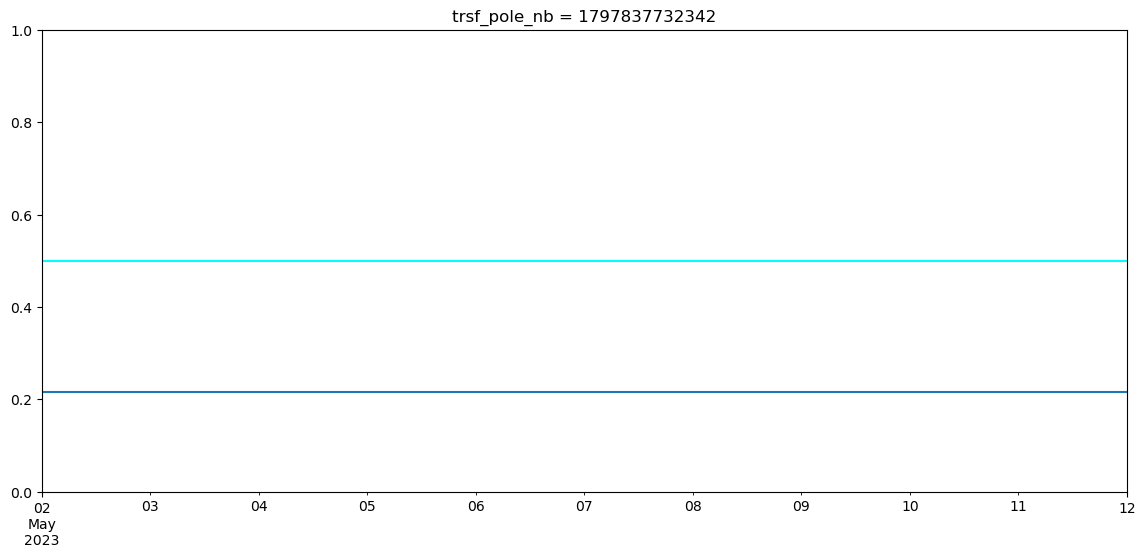

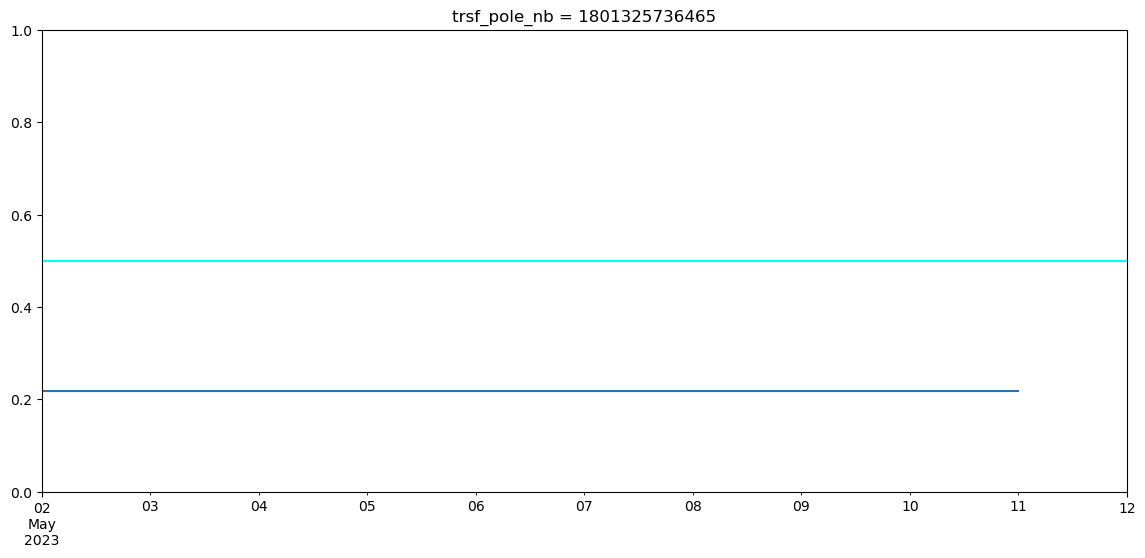

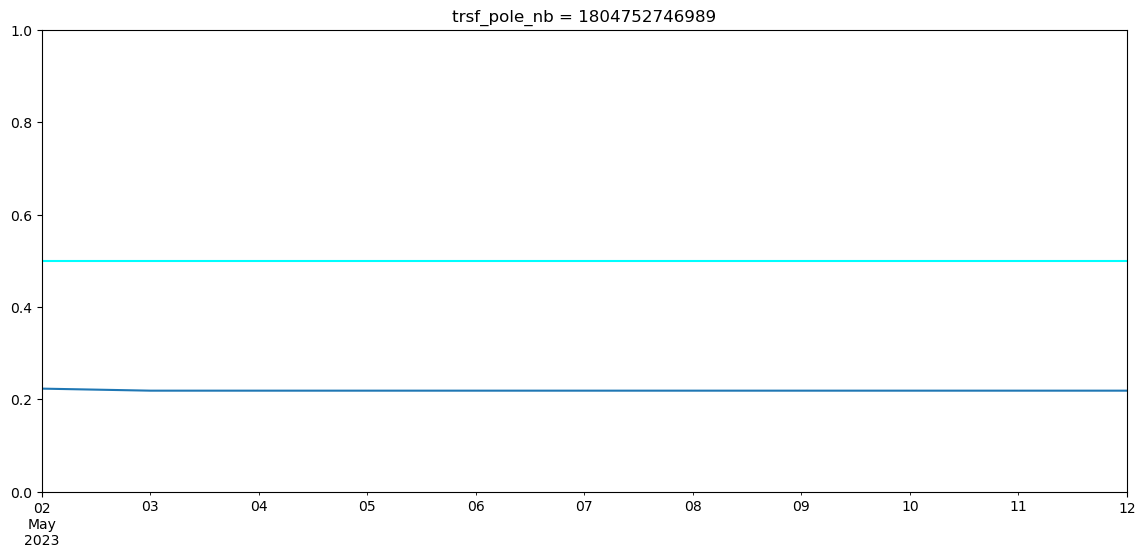

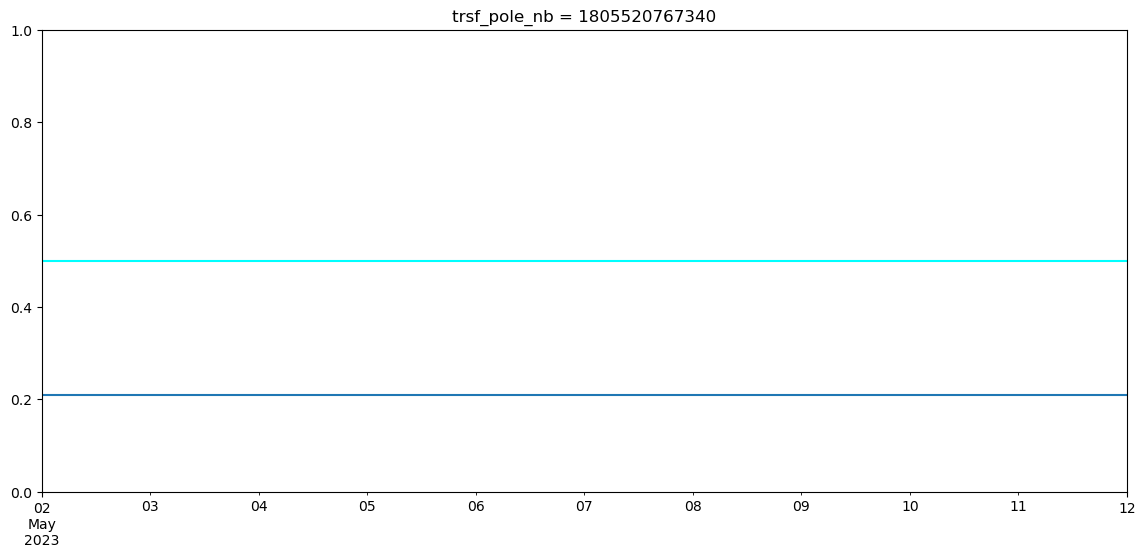

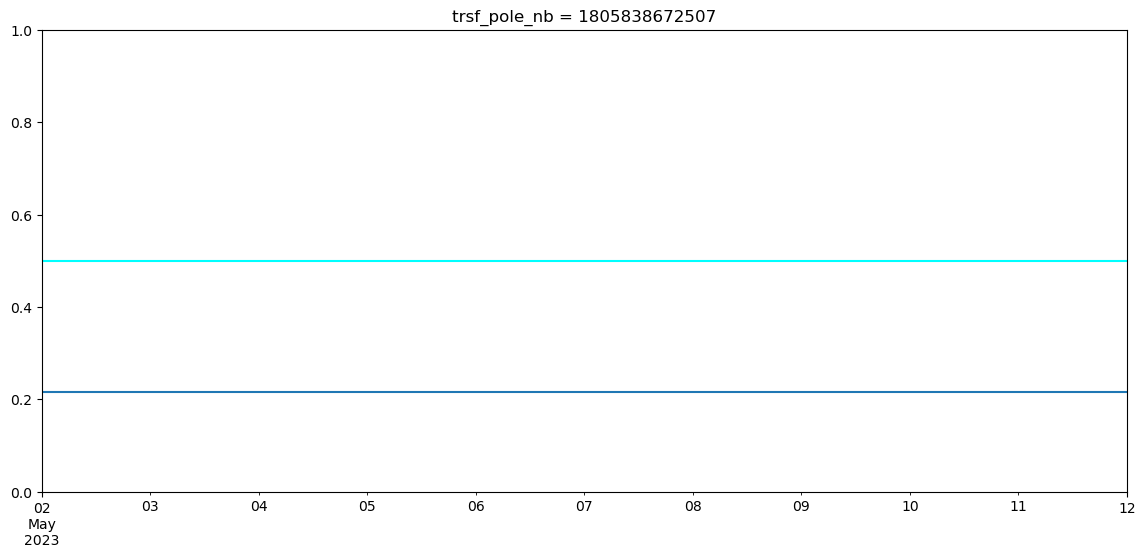

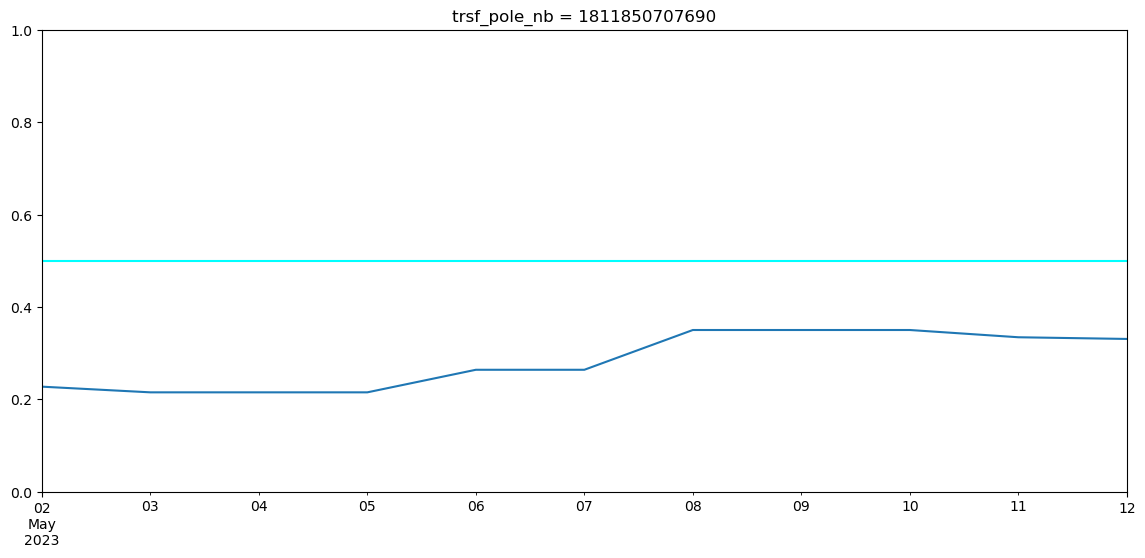

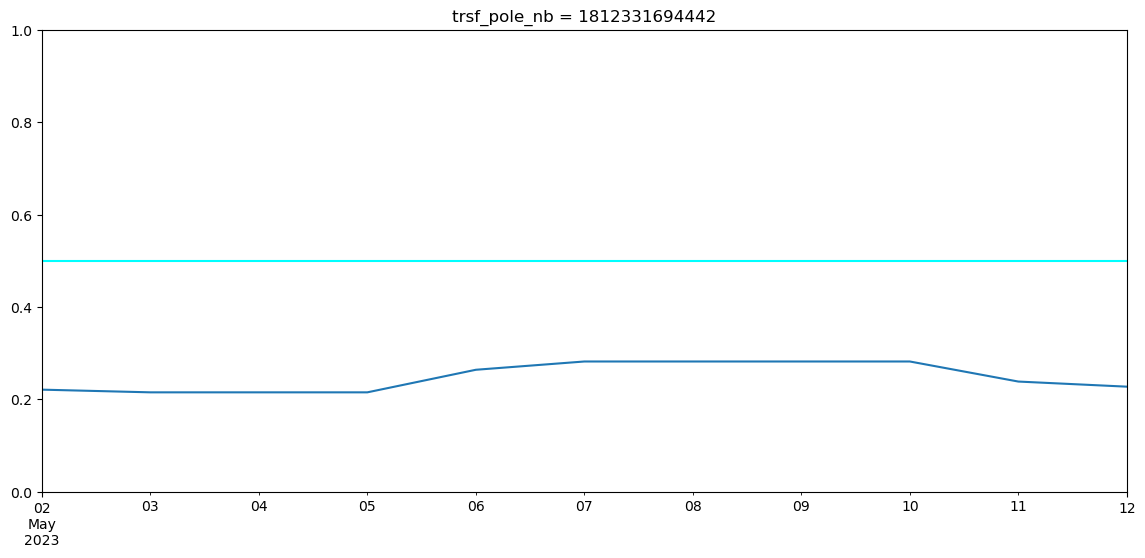

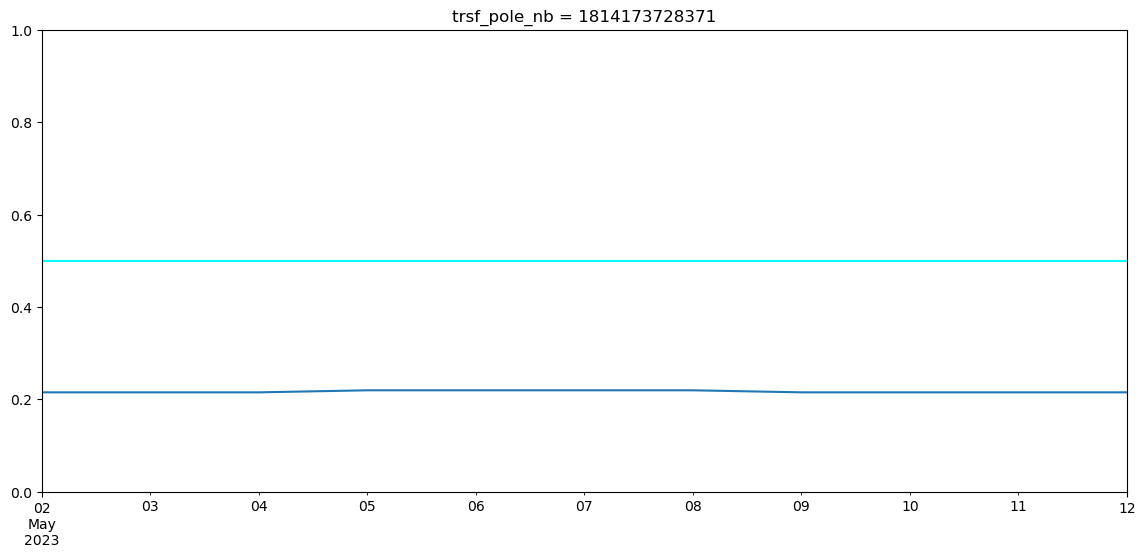

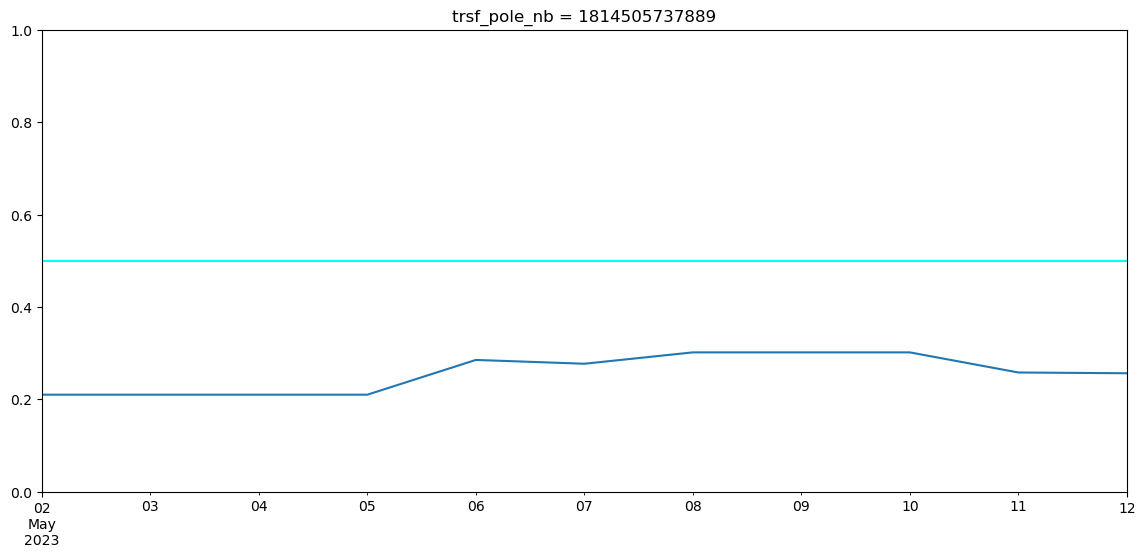

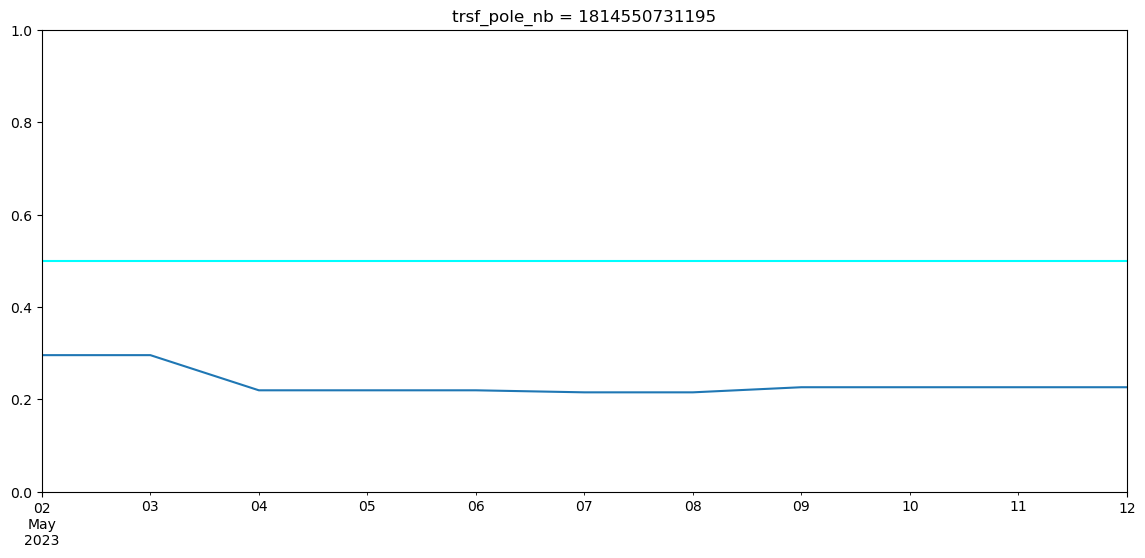

In [91]:
for trsf_pole_nb_i in y_prob1_by_date_df.index.tolist()[:20]:
    plot_pred_probs_for_trsf_i(
        fig_num            = fig_num, 
        trsf_pole_nb_i     = trsf_pole_nb_i, 
        y_prob1_by_date_df = y_prob1_by_date_df, 
        dovs_df            = dovs_df, 
        trsf_pole_nb_col   = 'trsf_pole_nb', 
        outg_rec_nb_col    = 'OUTG_REC_NB', 
        dt_off_ts_full_col = 'DT_OFF_TS_FULL'
    )
    fig_num+=1

In [ ]:
# pdf_path = r'C:\Users\s346557\Documents\Predictions.pdf'
# pdf = PdfPages(pdf_path)

# for trsf_pole_nb_i in y_prob1_by_date_df.index.tolist():
#     fig, ax = plot_pred_probs_for_trsf_i(
#         fig_num            = fig_num, 
#         trsf_pole_nb_i     = trsf_pole_nb_i, 
#         y_prob1_by_date_df = y_prob1_by_date_df, 
#         dovs_df            = dovs_df, 
#         trsf_pole_nb_col   = 'trsf_pole_nb', 
#         outg_rec_nb_col    = 'OUTG_REC_NB', 
#         dt_off_ts_full_col = 'DT_OFF_TS_FULL'
#     )
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.close(fig)
#     fig_num+=1
# pdf.close()